In [1]:
import nibabel as nib 
import nilearn.plotting as niplt 
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline  

In [3]:
d="/jukebox/griffiths/bert-brains/"
#mask=nib.load(d+"21styear_data/whole_brain_mask.nii.gz").get_fdata().astype('bool')

black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']

def get_result_dataset(result_dir):
    #print(result_dir)
    if 'slumlordreach' in result_dir:
        subs=slumlordreach_subs
    else:
        subs=black_subs
    parcelwise=np.zeros((len(subs),1000))
    for i,sub in enumerate(subs):
        parcelwise[i,:]=np.load(result_dir+sub+"_parcelwise_results.npy")
    return parcelwise 


In [7]:
def permutation_t_test(data1,data2): 
    diff=data1-data2
    stderr=np.std(diff,ddof=1)/np.sqrt(len(diff))+1e-9
    original_t=np.mean(diff)/stderr
    permutations=[]
    flip_diff=diff.copy()
    for _ in range(10000):
        flip_idxs=np.random.choice([0,1],size=len(diff),replace=True).astype('bool')
        flip_diff[flip_idxs]=diff[flip_idxs]*-1
        flip_diff[~flip_idxs]=diff[~flip_idxs]  
        flip_stderr=np.std(flip_diff,ddof=1)/np.sqrt(len(flip_diff))+1e-9 
        permutations.append(np.mean(flip_diff)/flip_stderr)
    permutations=np.asarray(permutations)

    if original_t<0:
        p_value=float(np.sum(permutations<=original_t))/len(permutations)
    else:
        p_value=float(np.sum(permutations>=original_t))/len(permutations)
    return original_t,p_value

In [48]:
from scipy.stats import ttest_rel
import statistics 
def get_individual_story_preference_map(story):
    layer_names=['layer_'+str(i)+"_activations" for i in range(0,13)] 
    save_prefix=d+"results/"+story+"/"
    save_dirs=[save_prefix+"encoding-"+layer+"/" for layer in layer_names]

    parcelwise=np.asarray([get_result_dataset(d) for d in save_dirs])

    parcellation_nii=nib.load(d+story+"_data/Schaefer1000_3mm.nii.gz")
    parcellation=parcellation_nii.get_fdata().astype('int')

    preference_parcels=np.zeros((1000,)).astype('int')

    for p in range(1000):
        #print(p)
        
        step=12
        data_p=parcelwise[:,:,p]
        vals,counts=np.unique(np.argmax(data_p,axis=0),return_counts=True)
        preference_parcels[p]=vals[np.argmax(counts)]
    
    preference_volume=np.zeros(parcellation.shape)
    for p in range(1000):
        preference_volume[np.where(parcellation==p+1)]=preference_parcels[p]+1
    return nib.Nifti1Image(preference_volume,parcellation_nii.affine)

def get_combined_preference_map():
    datas=[]
    for story in ['black','slumlordreach']:
        layer_names=['layer_'+str(i)+"_activations" for i in range(0,13)] 
        save_prefix=d+"results/"+story+"/"
        save_dirs=[save_prefix+"encoding-"+layer+"/" for layer in layer_names]
        datas.append(np.asarray([get_result_dataset(d) for d in save_dirs]))
    parcelwise=np.concatenate(datas,axis=1)

    parcellation_nii=nib.load(d+story+"_data/Schaefer1000_3mm.nii.gz")
    parcellation=parcellation_nii.get_fdata().astype('int')

    preference_parcels=np.zeros((1000,)).astype('int')

    for p in range(1000):
        #print(p)
        
        step=12
        data_p=parcelwise[:,:,p]
        #vals,counts=np.unique(np.argmax(data_p,axis=0),return_counts=True)
        #preference_parcels[p]=vals[np.argmax(counts)]
        preference_parcels[p]=np.argmax(data_p.mean(axis=1))
    
    preference_volume=np.zeros(parcellation.shape)
    for p in range(1000):
        preference_volume[np.where(parcellation==p+1)]=preference_parcels[p]+1
    return nib.Nifti1Image(preference_volume,parcellation_nii.affine)



black=get_individual_story_preference_map('black')
slumlord=get_individual_story_preference_map('slumlordreach')
combined=get_combined_preference_map()


/jukebox/griffiths/bert-brains/results/black/encoding-layer_0_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_1_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_2_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_3_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_4_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_5_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_6_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_7_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_8_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_9_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_10_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_11_activations/
/jukebox/griffiths/bert-brains/results/black/encoding-layer_12_activations/
/jukebox/griffiths/ber

In [49]:
set(black.get_fdata().flatten())

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0}

In [50]:
from pylab import *
import nilearn 
from nilearn import datasets 
def plot_surface(m):
    fsaverage = datasets.fetch_surf_fsaverage()
    roi_map=nilearn.surface.vol_to_surf(m,fsaverage['pial_left'],interpolation='nearest').astype('int')

    niplt.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_map,
                        hemi='left', view='lateral',
                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
                        darkness=.5,cmap = cm.get_cmap('jet', 13),colorbar=True,title="Layers")

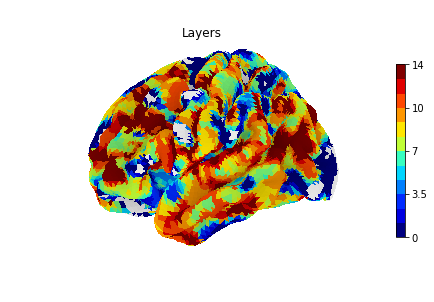

In [51]:
#Individual Black Preference Map 
plot_surface(black)

#cbar=fig.colorbar(x)



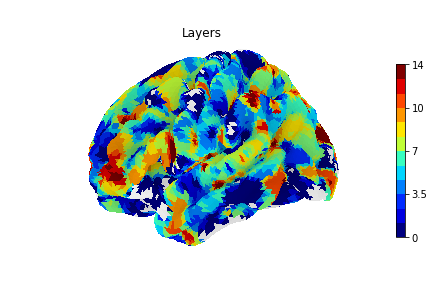

In [52]:
#Individual Slumlord Preference Map 
plot_surface(slumlord)

#cbar=fig.colorbar(x)



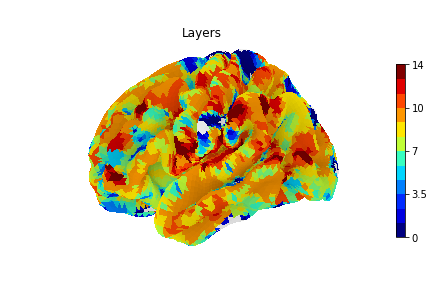

In [53]:
plot_surface(combined)